# Introduction to Moving Targets

> **COPYRIGHT NOTE**: this notebook has been taken from [here](https://github.com/lompabo/mt-tutorial/blob/main/Moving%20Target%20from%20Scratch.ipynb), with minor revisions and extensions in order to leverage the Moving Targets library. All the original material is indeed to be attributed to [@lompabo](https://github.com/lompabo).

This tutorial provides a running example showcasing both the behavior of [the Moving Targets algorithm](https://arxiv.org/abs/2002.10766) in a very simple setting, and how to leverage the existing API methods and classes for fast prototyping. 

Moving Targets (MT) is a decomposition-based approach that enables injecting constraints at training time in models for supervised Machine Learning. For example, it allows one to add fairness restrictions in classifiers, or take into account limitations due to physical laws in regression problems. MT achieves this by alternating "learner" steps, focusing on approximating a given target vector (i.e. a traditional ML task) and "master" steps, focusing on adjusting the target vector according to the constraints, the available data, and the current estimates from the ML model. The "moving" target vector gives the method its name.

Since master and learner step communicate only through the target vector, you are free to pick any kind of technology to address them: you can use Neural Networks or Random Forests for the learning, and anything from Projected Gradient to powerful Mathematical Programming solvers for the master. In this way, MT enables taking advantage of decades of research in constraint optimization, without needed to make changes to actual learning algorithms.

## The Toy Learning Problem

This tutorial addresses a toy regression problem with just two examples (data points), as the accurate visualization is possible. In particular, we will assume we want to fit a model in the form:
$$
\tilde{f}(x, \alpha) = x^\alpha
$$
based on two observations. This is a simple curve fitting problem, whereas the MT algorithm can deal with most supervised learning approaches in ML. That said, the problem simplicity will help to make clear how the method works.


The following cell defines the values of $x_m$ and $y_m$ for the two measured data points, i.e. $\hat{x}$ and $\hat{y}$

In [1]:
import numpy as np

xm = np.array([1.5, 3])
ym = np.array([1.2, 2.2])

In our example we will assume we know the actual data generation process (i.e. the true curve): since this is something that would never be available in real life, we will use it only to judge the quality of our fit and see how well the different approaches we try are working.

In particular, the true curve in our case is given by:
$$
f(x) = x^{0.579} 
$$

In the following cell we use an unnamed (lambda) function to define the curve, and we obtain the true $y_t$ values for our measurement points.

In [2]:
true_fn = lambda x: x ** 0.579

yt = true_fn(xm)
yt

array([1.26461066, 1.88909242])

We can now plot both the true curve and the measured $x_m, y_m$ points using a visualization utility function which has been moved into a separate `util` package in order to keep the notebook clean

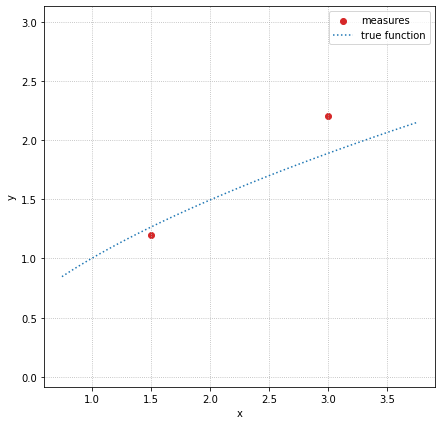

In [3]:
from util.introduction import function_plot

function_plot(xm, ym, true_fn=true_fn)

As we can see, our original measurements were a bit off: this happens all the time in the real world due to (e.g.) measurement noise, malfunctioning sensors, or typing errors.

More importantly, however, in this particular case we got a bit unlucky, since we have a small underestimation for the first measurement and some overestimation for the second one. This would likely lead an ML approach to thinking that the curve grows at a pace larger than the true one, which is exactly what we proceed to verify:

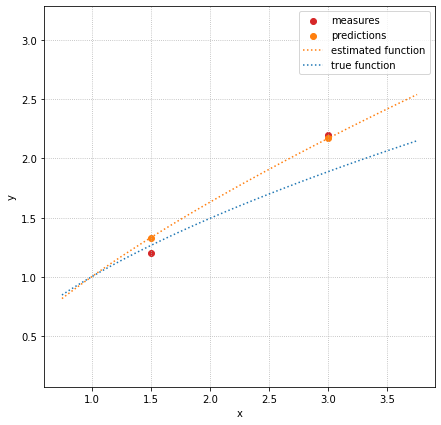

In [4]:
from scipy.optimize import curve_fit

curve = lambda x, alpha: x ** alpha
opt_alpha = curve_fit(curve, xm, ym)[0][0]

function_plot(xm, ym, true_fn=true_fn, pred_fn=lambda x: curve(x, opt_alpha))

We trained the model using a simple MSE loss, i.e. a basic supervised Machine Learning setup. 

As you can see, the learned model does indeed overestimate the curve slope.

More data would likely fix the issue in this case, but more data is not always available. Indeed, poor fits are a problem in many industrial use cases where data is scarce or noisy.

## Taking Advantage of Constraints

Now, let's assume we know that the curve value for our two measurements must obey:
$$
y_1 \leq \frac{3}{2} y_0
$$
in a real world setup, this information may come from example from physical limits or laws applicable to the considered process.

How do we take advantage of the constraint? The MT algorithm does so by reasoning in _output space_, i.e. in the space of all possible output for the ML model. In our case, this would be a plane where one axis corresponds to $y_0$ and the other to $y_1$.

In this representation, both the measured values and our current predictions _would appear as points_, respectively $(\hat{y}_0, \hat{y}_1)$ and $(\tilde{y}_0, \tilde{y}_1)$. Moreover, by changing the $\alpha$ parameter in our ML model, we can change the prediction vector (the orange point in the plot), but only in a way that is consistent with the ML model that we are trying to fit, i.e. with the equation:
$$
y = x^\alpha
$$

Every $\alpha$ value will result in a different prediction vector (point in the plane): we can draw all of them, obtaining some kind of area or shape on the plane. In our case we will obtain a curve, since the ML model has a single parameter:

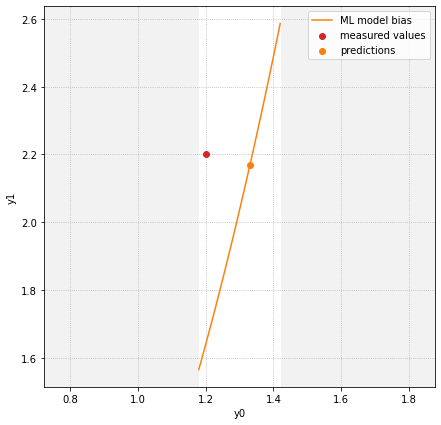

In [5]:
from util.introduction import output_plot

yp = curve(xm, opt_alpha)
output_plot(xm, ym, yp)

This curve (almost a straight line, in the considered range) represents the set of $(\tilde{y}_0, \tilde{y}_1)$ estimates that our ML model can output for the two measurements $(\hat{x}_0, \hat{x}_1)$. In Machine Learning terms, the curve represents the _bias_ of the model.

Notice how the measured output $\hat{y}$ does not fall within the bias? That means that the model structure we have chosen (the equation $y = x^\alpha$) is not capable of touching the two measurements.

Similarly to the ML model bias, our constraint:
$$
y_1 \leq \frac{3}{2} y_0
$$
identifies a second area on the plane, corresponding to the combinations of output values $(y_0, y_1)$ that are consistent with the inequality. The plotting function we are using can show this second area, too:

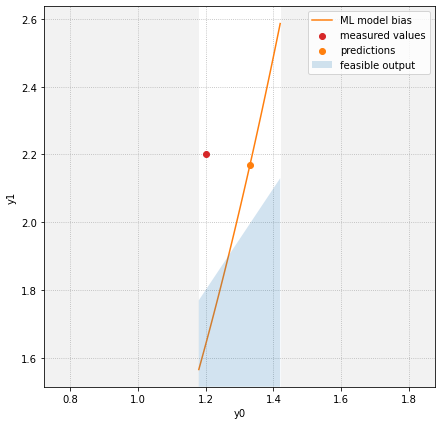

In [6]:
output_plot(xm, ym, yp, bound_fn=lambda y0: 1.5 * y0)

So, from the point of view of the Moving Target method, both the ML model bias and the constraints can be seen as very similar objects, namely _sets in the output space_.

Our goal is finding a point that is:

* In the intersection of the orange and blue areas (ML model bias and feasible set)
* As close as possible in terms of loss to the red dot (the measured values)

In our picture, this is the point where the orange line first touches the blue area.

## Moving Targets

Now that we have clarified how different things (measured values, predictions, bias, constraints...) look in output space, we are ready to tackle the Moving Target method itself and its APIs.

### The Method

The MT algorithm alternates "learner steps", i.e. traditional Machine Learning tasks, and "master steps", where the target vector is adjusted to account for the constraints. Usually, one starts with a learner (pretraining) step, such as the one we have already performed when training our ML model. If this step can be solved to optimality, as in our simple case, it will provide us with an output vector (predictions) that is as close as possible to the measured values, with closeness being measured in terms of the chosen loss function. In the picture, we can see that the orange dot (model predictions) is simply the Euclidean projection of the red dot (measured values) on the orange line. The projection is Euclidean in this case since we chose the MSE as our loss function.

From this point, the MT method will run a master step. This consists in finding a point in output space that is:

* Feasible according to the constraints
* Relatively close to _both_ the measured vector $\hat{y}$ and the prediction vector $\tilde{y}$

Once again, closeness is measured in terms of the chosen loss function. The distance between $\hat{y}$ and $\tilde{y}$ is balanced using a parameter $\alpha_k$ (which may vary between one iteration $k$ and the others). In particular, we look for a feasible point that minimizes:
$$
\alpha_k \cdot \nabla L(z, \hat{y}) \cdot (z - \tilde{y}) + \mid z - \tilde{y} \mid_2^2
$$
with $L$ being a custom loss function (e.g., mean squared error) and $z$ the vector of "moving" targets to optimize.

This is a constrained optimization problem, defined _entirely in output space_. In practice, it means that:

* We don't have to deal with the ML model when considering the constraints. This is super handy since ML models can be large and rather nasty to take into account in constrained optimization.
* We can solve the problem with any technique that makes sense, ranging from classical numerical optimization methods to powerful Mathematical Programming, Constraint Programming, or SAT Modulo Theory solvers.

### The Library

In order to simplify the development efforts, we will leverage the `moving-targets` library both for this and the following tutorials. The library, which can be installed via `pip install moving-targets`, contains the implementation of various learners and masters, as well as many utility classes and functions for measuring and plotting custom training information.

We will now use the three main objects of the library: (1) a `Learner` object which encapsulates the MT learner step, (2) a `Master` object which encapsulates the MT master step, and (3) a `MACS` object which encapsulates the whole MT algorithm. Additionally, we will use two predefined metrics (i.e., `MSE` and `R2`) to plot the evolution of the training respectively to each MT iteration.

In particular, the `Learner` is indeed a wrapper of the `scipy` curve_fit method to match the same ML algorithm that we used above while the `Master` is a custom class implementing the constraint:
$$
y_1 <= \frac{3}{2} y_0
$$

Notice that the constraint is formulated inside the `build` method, where the input parameter $y$ represents the true target $\hat{y}$, the input parameter $p$ represents the predicted targets $\tilde{y}$, while the variable $z$ represents the "moving" targets that we aim to optimize. Furthermore, the constraint is implemented using the inner `backend` object, which in this case leverages the `cvxpy` non-commercial solver, and the minimization is carried out considering a mean squared error as the $L$ loss function and fixed $\alpha$ with value $10^{-3}$.

Notice that we chose a small $\alpha$, so the adjusted target vector (blue dot) almost matches the projection of the prediction vector (orange dot) on the feasible set (blue area). "Almost", since it is slightly nearer to the measured vector (red dot) than it should otherwise be: this is due to the $L(z, \hat{y})$ term in the cost function of the master step. Picking a good value for $\alpha$ may require some trial and error: large values may not guarantee convergence (even in an all-convex case), while too small values may lead to slow convergence. The MT library provides as well a few range of alpha optimizers, the default one being the harmonic optimizer which, starting from an $\alpha_0$, computes the alpha value at the $k^{th}$ iteration as $\alpha_k = \frac{1}{k} \cdot \alpha_0$

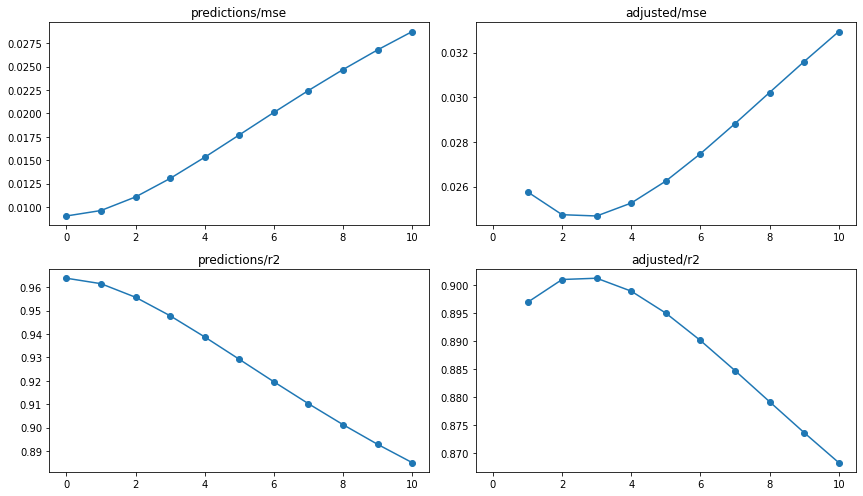

In [7]:
from moving_targets import MACS
from moving_targets.learners import ScipyCurveFit
from moving_targets.masters import RegressionMaster
from moving_targets.metrics import MSE, R2

class CustomMaster(RegressionMaster):
    def __init__(self):
        super(CustomMaster, self).__init__(backend='cvxpy', loss='mse', alpha=1e-3)

    def build(self, x, y, p):
        z = super(CustomMaster, self).build(x, y, p)
        self.backend.add_constraint(z[1] <= 1.5 * z[0])
        return z

lrn = ScipyCurveFit(curve=lambda x, alpha: x ** alpha)
mst = CustomMaster()
mtr = [MSE(), R2()]
model = MACS(learner=lrn, master=mst, metrics=mtr)
model.fit(xm, ym, iterations=10, verbose=False).plot(figsize=(12, 7))

By looking at the training history, we can see how both the predicted ($\tilde{y}$) and the adjusted ($z$) targets tend to move away from the original targets ($\hat{y}$), resulting in a higher loss and lower accuracy score.

While in principle this may seem to be an undesired effect, we should acknowledge that the measured data points are noisy, therefore basing our performances just on the metrics may lead to wrong conclusions.

In order to further inspect the MT algorithm functioning, we can build a custom callback which allow to enter the MT training loop and get (or log) more specific information. In particular, we can create a list of predicted and adjusted targets, one per iteration, and eventually plot them in the output space:

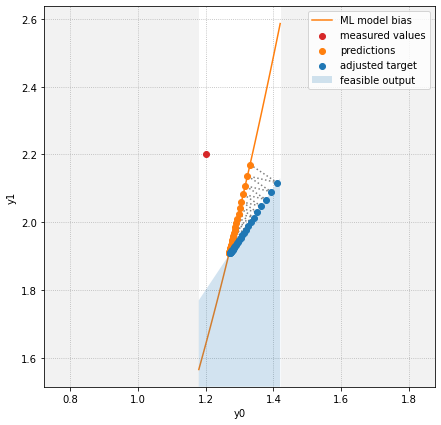

In [8]:
from moving_targets.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        self.p_list = []
        self.z_list = []

    def on_training_end(self, macs, x, y, p, val_data):
        self.p_list.append(p)

    def on_adjustment_end(self, macs, x, y, z, val_data):
        self.z_list.append(z)

    def on_process_end(self, macs, x, y, val_data):
        output_plot(x, y, p=self.p_list, z=self.z_list, bound_fn=lambda y0: 1.5 * y0)

model = MACS(learner=ScipyCurveFit(curve=lambda x, alpha: x ** alpha), master=CustomMaster())
model.fit(xm, ym, iterations=30, callbacks=[CustomCallback()], verbose=False);

Notice how the method zig-zags ever closer to the best possible prediction vector.

If you know about numerical optimization this zig-zag behavior may look both bad and avoidable, but in practice it's the price we pay to keep the ML and the constraint handling parts completely separated, i.e. the main advantage of the MT method.

Finally, since we know our ground truth, we may have a look at which kind of learned function we may obtain after enough iterations to get close to convergence. Here it comes:

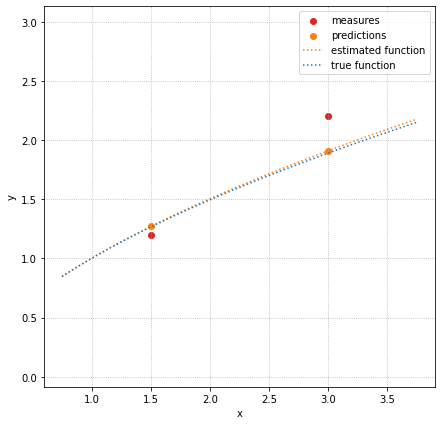

In [9]:
function_plot(xm, ym, true_fn=true_fn, pred_fn=model.predict)

Thanks to the use of the additional constraint (basically: domain knowledge in symbolic form), we managed to get an estimated function that is very close to the true one.

Of course this is a toy example designed to showcase this very behavior, so don't take this success too optimistically ;-)

## Conclusions

If things have gone as planned, you should now have a much better idea of how the Moving Target method works, and especially how things look like from the perspective of the output space. If you want to have a full picture ot the method you will need to [check the paper](https://arxiv.org/abs/2002.10766) or dive deep inside [the library](https://github.com/moving-targets/moving-targets).

As a rule of thumb, using MT instead of other methods for injecting constraints in ML model may be interesting when:

* Your constraints are not natively differentiable (e.g. they are defined on discrete variables). You can just use a combinatorial solver to deal with them!
* Your constraints are defined on a large number of examples (e.g. fairness indicators). You can focus on tackling them in output space, without any possibly huge ML model in the way.
* Dealing with the constraint via alternative methods (e.g. regularization/Lagrangian approaches) slows down training a lot.

MT is not a silver bullet, but we think it's a valuable tool to inject constraints in ML model. We hope you found this whole thing interesting as well :-)